In [ ]:
!unzip /content/drive/MyDrive/ICG.zip -d content

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [15]:
Images = glob.glob(os.path.join('/content/content/Images','*.jpg'))

In [16]:
import cv2
count=0
images=[]
I_names=[]
for img_dir in Images:
    count+=1
    c = img_dir.split('/')[-1]
    I_names.append(c) 
    image = cv2.imread(img_dir)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    image = image.reshape((1,224,224,3))
    images.append(image)
    if count==2000:
        break

In [17]:
len(I_names)

2000

In [44]:
I_names[0]

'3178489390_13a6ae7524.jpg'

In [43]:
import tensorflow
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
Feature_extractor = VGG16()
model = Model(inputs = Feature_extractor.input,outputs = Feature_extractor.layers[-2].output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [46]:
features = {}
count=0
for i in range(len(images)):
    count+=1  
    image = model.predict(images[i])
    features[I_names[i]]=image
    if count%500==0:
      print(count)

500
1000
1500
2000


In [47]:
with open('/content/drive/MyDrive/ICP/features.pkl','wb') as f:
  pickle.dump(features,f)

In [48]:
file = open('/content/drive/MyDrive/ICP/features.pkl','rb')
features = pickle.load(file)

In [49]:
with open('/content/content/captions.txt','r') as f:
  captions = f.readlines()


In [50]:
Cap_dic = {}
for cap in captions:
  line = cap.rstrip()
  x = line.split(',')
  img = x[0]
  if img in I_names:
   caption = ' '.join(x[1:])
   if img in Cap_dic:
     Cap_dic[img]+=[caption]    
   else:
       Cap_dic[img]=[caption] 

In [51]:
len(list(Cap_dic.keys()))

2000

In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [53]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption
    return mapping

In [54]:
Data = clean(Cap_dic)

In [55]:
all_captions = []
for key in Data:
    for caption in Data[key]:
        all_captions.append(caption)

In [56]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [57]:
vocab_size

4529

In [58]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

30

In [59]:
image_ids = list(Data.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [61]:
# create data generator to get data in batch (avoids session crash)
from tensorflow.keras.utils import to_categorical
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [62]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

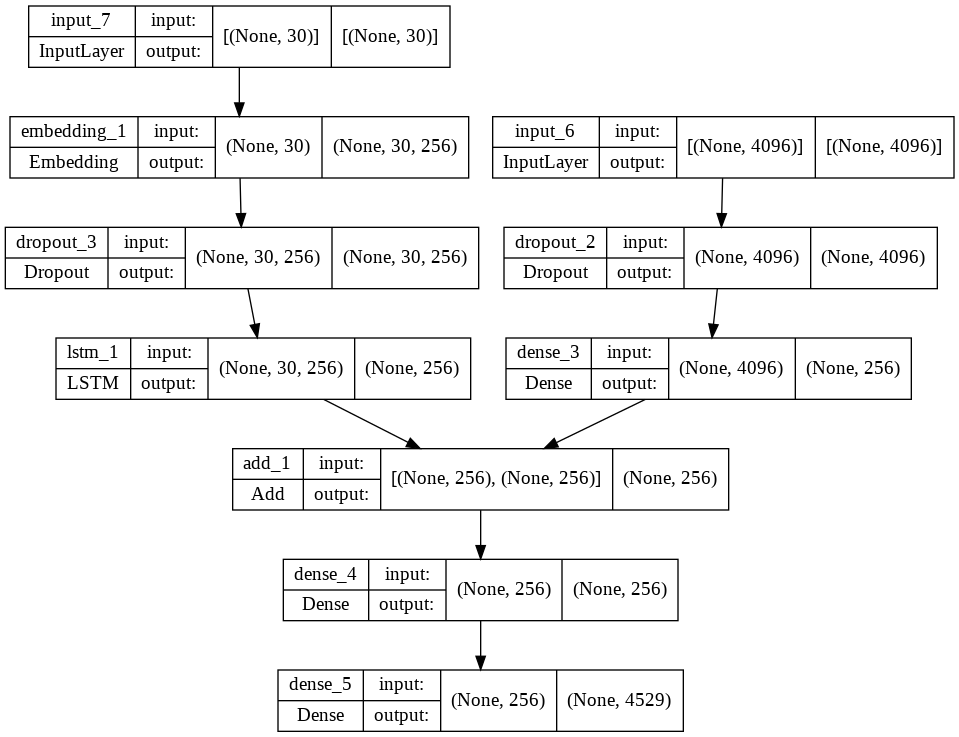

In [63]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [64]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train,Data, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

56/56 [==============================] - 12s 206ms/step - loss: 2.1995


In [65]:
# save the model
model.save('/content/drive/MyDrive/ICP/best_model.h5')

In [66]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [67]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq '
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == ' endseq':
            break
      
    return in_text

In [69]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = Data[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/200 [00:00<?, ?it/s]

BLEU-1: 0.184355
BLEU-2: 0.099313


In [80]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = Data[image_name]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_name], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq child in an orange t-shirt is riding green bike beside pathway endseq
startseq child in red is riding bicycle endseq
startseq child wearing helmet is riding baby bicycle by side of walk path endseq
startseq little girl is riding her bike on dirt trail endseq
startseq young child is riding bike in the dirt along brick walkway in park endseq
--------------------Predicted--------------------
startseq  young girl is riding bike down the walkway endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


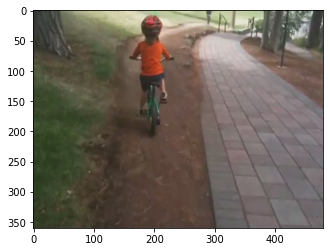

In [81]:
generate_caption('3701878677_8f2c26227b.jpg')